# Import all libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import os
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


# Load Datasets

In [ ]:
## Load emotion csv file for each candidate and concatenate them below each other so better representation of the data 

In [ ]:
dataframes = []

for i in range(1, 11):
    file_path = f"data/emotion_data/{i}/emotion.csv"    
    df = pd.read_csv(file_path)  
    df['candidate_id'] = i 
    columns = ['candidate_id'] + [col for col in df.columns if col != 'candidate_id']
    df =df[columns]
    dataframes.append(df)

In [ ]:
emotion_combined = pd.concat(dataframes, ignore_index=True)

In [ ]:
## Load gaze csv file for each candidate and concatenate them below each other so better representation of the data 

In [ ]:
dataframes = []

for i in range(1, 11):
    file_path = f"data/emotion_data/{i}/gaze.csv"    
    df = pd.read_csv(file_path)
    df['candidate_id'] = i 
    columns = ['candidate_id'] + [col for col in df.columns if col != 'candidate_id']
    df =df[columns]
    dataframes.append(df)

In [ ]:
gaze_combined = pd.concat(dataframes, ignore_index=True)

In [ ]:
## combine emotion csv and gaze csv file as there is only a few data poits lost 

In [ ]:
emotion_gaze_combined = pd.merge(emotion_combined, gaze_combined, on=['candidate_id','movie_id', 'image_seq'], how='left')

In [ ]:
## Load transcripts csv file for each candidate and concatenate them below each other so better representation of the data 

In [ ]:
dataframes = []

for i in range(1, 11):
    file_path = f"data/transcript_data/{i}.csv"    
    df = pd.read_csv(file_path)   
    df['candidate_id'] = i 
    columns = ['candidate_id'] + [col for col in df.columns if col != 'candidate_id']
    df =df[columns]
    dataframes.append(df)

In [ ]:
transcripts_combined = pd.concat(dataframes, ignore_index=True)

In [ ]:
## Load transcripts.txt file for each candidate and concatenate them below each other so better representation of the data 

In [ ]:
data = []
folder_path = "data/transcripts/" 

for i in range(1, 11): 
    file_path = os.path.join(folder_path, f"{i}.txt")  
    with open(file_path, 'r') as file:
        transcript_text = file.read() 
        data.append({'candidate_id': i, 'transcript_text': transcript_text})  


transcripts = pd.DataFrame(data)

### General overview of the data 

### Check for null values 

# Calculate positive communication score and negative communication score

In [ ]:
positive_columns = ['positive', 'confident', 'concise', 'enthusiastic']
negative_columns = ['negative', 'hesitant']

# Function to calculate communication scores for each candidate
def calculate_communication_scores(df):
        
    # Group by candidate_id and calculate mean scores for positive and negative traits
    positive_scores = df.groupby('candidate_id')[positive_columns].mean()
    negative_scores = df.groupby('candidate_id')[negative_columns].mean()

    # Sum the positive and negative scores to get total positive and negative communication skills
    positive_communication = positive_scores.mean(axis=1)
    negative_communication = negative_scores.mean(axis=1)
    
    # Calculate overall communication score by subtracting negative from positive
    overall_communication = positive_communication - negative_communication

    # Return the resulting DataFrame with all the scores
    result = pd.DataFrame({
        'positive_communication': positive_communication,
        'negative_communication': negative_communication,
        'overall_communication': overall_communication
    })

    return result

# Apply the function to the dataset (either transcripts_combined or emotion_gaze_combined)
communication_scores = calculate_communication_scores(transcripts_combined)

# Display the communication scores for each candidate
print(communication_scores)


In [ ]:
communication_scores['candidate_label'] = ['candidate-' + str(i + 1) for i in range(len(communication_scores))]

# Set up the figure for the combined plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the bar width
bar_width = 0.4
index = range(len(communication_scores))

# Define the same colors for positive and negative communication skills
positive_color = '#005EB8'  # Dark blue
negative_color = '#C82333'  # Dark red

# Plot positive communication scores
bars_pos = ax.bar([i - bar_width / 2 for i in index], communication_scores['positive_communication'], width=bar_width, color=positive_color, label='Positive Communication')

# Plot negative communication scores
bars_neg = ax.bar([i + bar_width / 2 for i in index], communication_scores['negative_communication'], width=bar_width, color=negative_color, label='Negative Communication')

# Add labels and title
ax.set_xlabel('Candidates')
ax.set_ylabel('Communication Scores')
ax.set_title('Positive and Negative Communication Skills for Candidates')

# Set x-ticks to the center position of the bars and add candidate labels
ax.set_xticks(index)
ax.set_xticklabels(communication_scores['candidate_label'], rotation=0)  # Display candidate labels

# Add a horizontal line at zero
ax.axhline(0, color='black', linewidth=0.8)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
# plt.savefig('negative_and_positive_communication_score_per_candidate_side_by_side_with_labels.png', dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Create colors based on the overall communication score (Red for negative, Blue for positive)
colors = [
    plt.cm.Reds(np.abs(score) / max(communication_scores['overall_communication'].abs())) if score < 0
    else plt.cm.Blues(np.abs(score) / max(communication_scores['overall_communication'].abs()))
    for score in communication_scores['overall_communication']
]

# Create barplot for overall communication scores
bars = plt.bar(communication_scores.index, communication_scores['overall_communication'], color=colors)

# Annotate each bar with "candidate-1", "candidate-2", etc.
for bar, idx in zip(bars, range(len(communication_scores))):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'candidate-{idx + 1}', ha='center', va='bottom' if yval > 0 else 'top')

# Add labels and title
plt.title('Overall Communication Scores by Candidate')
plt.ylabel('Overall Communication Score')
plt.xlabel('Candidate ID')

# Save the plot as an image (PNG)
plt.tight_layout()
# plt.savefig('overall_communication_scores_with_annotation.png', dpi=300)
# Show the plot
plt.show()

# calculate positive and negative emotions scores

In [ ]:
positive_emotions = ['happy', 'surprise']
negative_emotions = ['angry', 'disgust', 'fear', 'sad']

# Initialize dictionaries to store scores for each candidate
positive_emotion_scores = {}
negative_emotion_scores = {}

# Loop through each candidate to calculate average positive and negative emotions
for candidate_id in emotion_gaze_combined['candidate_id'].unique():
    # Filter the data for the current candidate
    candidate_data = emotion_gaze_combined[emotion_gaze_combined['candidate_id'] == candidate_id]
    
    # Calculate average positive emotion score
    positive_emotion_scores[candidate_id] = candidate_data[positive_emotions].mean(axis=1).mean()
    
    # Calculate average negative emotion score
    negative_emotion_scores[candidate_id] = candidate_data[negative_emotions].mean(axis=1).mean()

# Convert dictionaries to DataFrame for easier handling
emotion_scores = pd.DataFrame({
    'candidate_id': list(positive_emotion_scores.keys()),
    'positive_emotion_score': list(positive_emotion_scores.values()),
    'negative_emotion_score': list(negative_emotion_scores.values())
})

# Calculate overall emotion score (positive - negative)
emotion_scores['overall_emotion_score'] = emotion_scores['positive_emotion_score'] - emotion_scores['negative_emotion_score']

# Print the final emotion scores
print("Emotion Scores for Each Candidate:")
print(emotion_scores)

In [ ]:
positive_emotions = ['happy', 'surprise']
negative_emotions = ['angry', 'disgust', 'fear', 'sad']

# Initialize dictionaries to store scores for each candidate
positive_emotion_scores = {}
negative_emotion_scores = {}

# Loop through each candidate to calculate average positive and negative emotions
for candidate_id in emotion_gaze_combined['candidate_id'].unique():
    # Filter the data for the current candidate
    candidate_data = emotion_gaze_combined[emotion_gaze_combined['candidate_id'] == candidate_id]
    
    # Calculate average positive emotion score
    positive_emotion_scores[candidate_id] = candidate_data[positive_emotions].mean(axis=1).mean()
    
    # Calculate average negative emotion score
    negative_emotion_scores[candidate_id] = candidate_data[negative_emotions].mean(axis=1).mean()

# Convert dictionaries to DataFrame for easier handling
emotion_scores = pd.DataFrame({
    'candidate_id': list(positive_emotion_scores.keys()),
    'positive_emotion_score': list(positive_emotion_scores.values()),
    'negative_emotion_score': list(negative_emotion_scores.values())
})

# Calculate overall emotion score (positive - negative)
emotion_scores['overall_emotion_score'] = emotion_scores['positive_emotion_score'] - emotion_scores['negative_emotion_score']

# Plotting positive, negative, and overall emotion scores for each candidate
plt.figure(figsize=(12, 6))

# Create colors based on the overall emotion score (Red for negative, Blue for positive)
colors = [
    plt.cm.Reds(np.abs(score) / max(emotion_scores['overall_emotion_score'].abs())) if score < 0
    else plt.cm.Blues(np.abs(score) / max(emotion_scores['overall_emotion_score'].abs()))
    for score in emotion_scores['overall_emotion_score']
]

# Create barplot
bars = plt.bar(emotion_scores['candidate_id'], emotion_scores['overall_emotion_score'], color=colors)

# Annotate each bar with "candidate-1", "candidate-2", etc.
for bar, idx in zip(bars, range(len(emotion_scores))):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'candidate-{idx + 1}', ha='center', va='bottom' if yval > 0 else 'top')

# Add labels and title
plt.title('Overall Emotion Scores by Candidate')
plt.ylabel('Overall Emotion Score')
plt.xlabel('Candidate ID')

# Save the plot as an image (PNG)
plt.tight_layout()
# plt.savefig('overall_emotion_scores_with_annotation.png', dpi=300)
# Show the plot
plt.show()

In [ ]:
positive_emotions = ['happy', 'surprise']
negative_emotions = ['angry', 'disgust', 'fear', 'sad']

# Initialize dictionaries to store scores for each candidate
positive_emotion_scores = {}
negative_emotion_scores = {}

# Loop through each candidate to calculate average positive and negative emotions
for candidate_id in emotion_gaze_combined['candidate_id'].unique():
    # Filter the data for the current candidate
    candidate_data = emotion_gaze_combined[emotion_gaze_combined['candidate_id'] == candidate_id]
    
    # Calculate average positive emotion score
    positive_emotion_scores[candidate_id] = candidate_data[positive_emotions].mean(axis=1).mean()
    
    # Calculate average negative emotion score
    negative_emotion_scores[candidate_id] = candidate_data[negative_emotions].mean(axis=1).mean()

# Convert dictionaries to DataFrame for easier handling
emotion_scores = pd.DataFrame({
    'candidate_id': list(positive_emotion_scores.keys()),
    'positive_emotion_score': list(positive_emotion_scores.values()),
    'negative_emotion_score': list(negative_emotion_scores.values())
})

# Create new labels "candidate-1", "candidate-2", ...
emotion_scores['candidate_label'] = ['candidate-' + str(i + 1) for i in range(len(emotion_scores))]

# Set up the figure for the combined plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the bar width
bar_width = 0.4
index = range(len(emotion_scores))

# Define darker colors for positive and negative emotions
positive_color = '#005EB8'  # Dark blue
negative_color = '#C82333'  # Dark red

# Plot positive emotion scores
bars_pos = ax.bar([i - bar_width / 2 for i in index], emotion_scores['positive_emotion_score'], width=bar_width, color=positive_color, label='Positive Emotions')

# Plot negative emotion scores
bars_neg = ax.bar([i + bar_width / 2 for i in index], emotion_scores['negative_emotion_score'], width=bar_width, color=negative_color, label='Negative Emotions')

# Add labels and title
ax.set_xlabel('Candidates')
ax.set_ylabel('Emotion Scores')
ax.set_title('Positive and Negative Emotion Scores for Candidates')

# Set x-ticks to the center position of the bars and add candidate labels
ax.set_xticks(index)
ax.set_xticklabels(emotion_scores['candidate_label'], rotation=0)  # Display candidate labels

# Add a horizontal line at zero
ax.axhline(0, color='black', linewidth=0.8)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('negative_and_positive_emotion_score_per_candidate_side_by_side_with_labels.png', dpi=300)
plt.show()

In [ ]:
# emotion_columns = ['happy', 'surprise', 'angry', 'disgust', 'fear', 'sad', 'neutral']

# # Loop through each candidate in the dataset
# for candidate_id in emotion_gaze_combined['candidate_id'].unique():
#     # Filter data for the current candidate
#     candidate_data = emotion_gaze_combined[emotion_gaze_combined['candidate_id'] == candidate_id]

#     # Calculate the percentage of each emotion
#     emotion_counts = candidate_data[emotion_columns].sum()  # Sum of emotions
#     total_counts = emotion_counts.sum()  # Total counts of emotions
#     emotion_percentage = (emotion_counts / total_counts) * 100  # Calculate percentage

#     # Create a heatmap for the candidate's emotions over image sequence
#     plt.figure(figsize=(12, 6))
    
#     # Transpose the data to have emotions on the y-axis
#     heatmap_data = candidate_data[emotion_columns].T
#     sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, cbar=True, linewidths=0.5)

#     # Set the x-ticks to match the image_seq values but reduce to every nth value for readability
#     n = max(1, len(candidate_data) // 10)  # Display 1 out of n ticks
#     plt.xticks(ticks=range(0, len(candidate_data), n), 
#                labels=candidate_data['image_seq'].values[::n], rotation=90)

#     # Title and labels
#     plt.title(f'Change in Emotions for Candidate {candidate_id}', pad=20)  # Increased padding
#     plt.xlabel('Image Sequence')
#     plt.ylabel('Emotion')

#     # Set the y-ticks to be the emotion names without repeating on every emotion
#     plt.yticks(ticks=range(len(emotion_columns)), labels=emotion_columns, rotation=0)

#     # Annotate the percentage outside the plot area to the right of the heatmap
#     for idx, percentage in enumerate(emotion_percentage):
#         plt.text(len(candidate_data) + 0.5, idx + 0.5, f'{percentage:.1f}%', 
#                  ha='left', va='center', fontsize=10, color='black')

#     # Adjust layout to prevent overlap
#     plt.subplots_adjust(top=0.85, right=0.85)  # Adjust the right margin to fit percentages
    
#     # Save the plot as an image (PNG) with a unique filename for each candidate
#     plt.savefig(f'candidate_{candidate_id}_emotion_changes_with_percentage_outside.png', dpi=300)
    
#     # Show the plot
#     plt.show()

### correlation between emotions 

             happy  surprise     angry   disgust      fear       sad   neutral
happy     1.000000 -0.072263 -0.125228 -0.004104 -0.178267 -0.136097 -0.353837
surprise -0.072263  1.000000  0.007399  0.002893  0.036954 -0.176636 -0.279242
angry    -0.125228  0.007399  1.000000  0.193036 -0.002004  0.020198 -0.269123
disgust  -0.004104  0.002893  0.193036  1.000000  0.052634  0.024602 -0.136343
fear     -0.178267  0.036954 -0.002004  0.052634  1.000000  0.056354 -0.581526
sad      -0.136097 -0.176636  0.020198  0.024602  0.056354  1.000000 -0.406517
neutral  -0.353837 -0.279242 -0.269123 -0.136343 -0.581526 -0.406517  1.000000


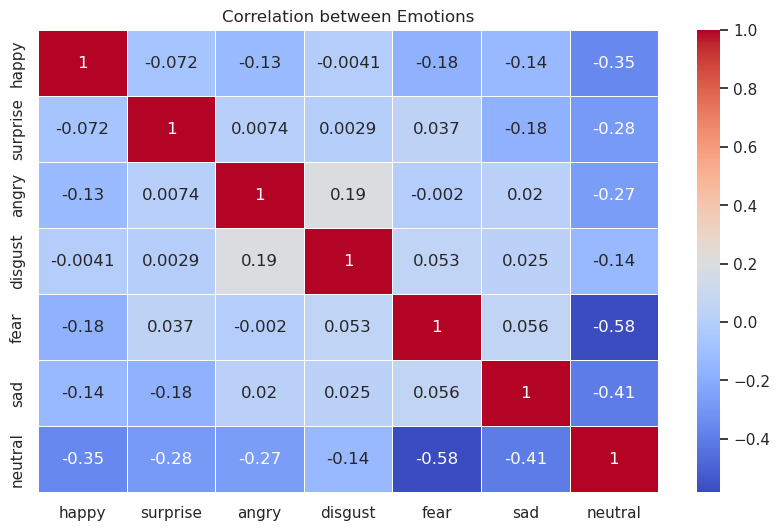

In [66]:
emotion_columns = ['happy', 'surprise', 'angry', 'disgust', 'fear', 'sad', 'neutral']

# Calculate the correlation matrix
correlation_matrix = emotion_gaze_combined[emotion_columns].corr()

# Print the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.savefig('emotions_correlation.png', dpi=300)
plt.title('Correlation between Emotions')
plt.show()

### calculating and ploting dominant emotion

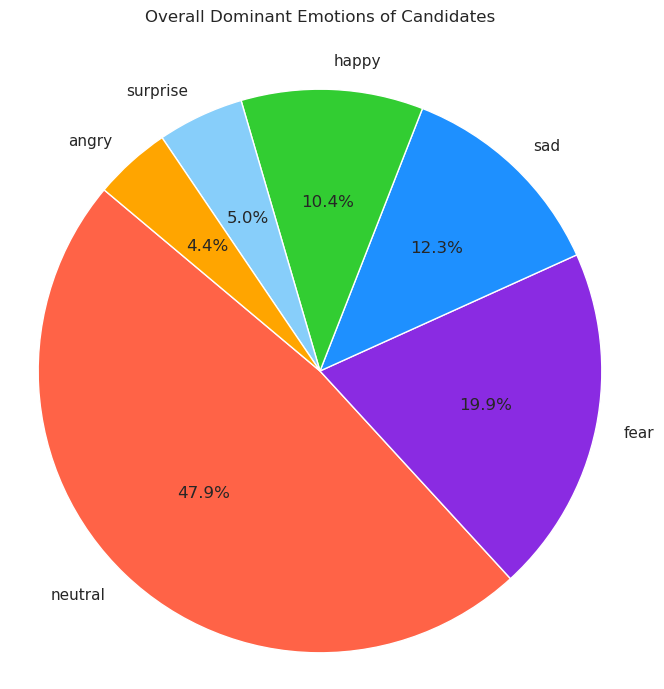

In [67]:
emotion_columns = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Create a new column to hold the dominant emotion for each row
def get_dominant_emotion(row):
    return row[emotion_columns].idxmax()  # Returns the column name of the max score

# Apply the function to get the dominant emotion for each row
emotion_gaze_combined['dominant_emotion'] = emotion_gaze_combined.apply(get_dominant_emotion, axis=1)

# Calculate the overall dominant emotion for each candidate
dominant_emotion_over_time = emotion_gaze_combined['dominant_emotion'].value_counts()

# Plotting Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(dominant_emotion_over_time, labels=dominant_emotion_over_time.index, autopct='%1.1f%%', startangle=140,
        colors=['#FF6347', '#8A2BE2', '#1E90FF', '#32CD32', '#87CEFA', '#FFA500', '#A9A9A9'])
plt.title('Overall Dominant Emotions of Candidates', pad=30)  # Add padding to the title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('overall_dominant_emotions_of_candidates.png', dpi=300)

# Show the plot
plt.show()

### correlation between emotions 

In [55]:
emotion_gaze_combined.columns

Index(['candidate_id', 'movie_id', 'image_seq', 'angry', 'disgust', 'fear',
       'happy', 'sad', 'surprise', 'neutral', 'dominant_emotion', 'gaze',
       'blink', 'eye_offset'],
      dtype='object')

# calculate gaze related parameters 

### percentage of time looking at camera per candidate 

In [ ]:
gaze_distribution = emotion_gaze_combined.groupby('candidate_id')['gaze'].mean() * 100

# Plot gaze distribution for each candidate
gaze_distribution.plot(kind='bar', figsize=(10, 6), title='Percentage of Time Looking at Camera per Candidate')
plt.ylabel('Percentage')
plt.show()

In [ ]:
sns.set(style="whitegrid")

# Normalize the values for the gradient color
norm = plt.Normalize(gaze_distribution.min(), gaze_distribution.max())
colors = plt.cm.Blues(norm(gaze_distribution.values))

# Create the figure and axis objects
plt.figure(figsize=(12, 7))

# Plot the data with gradient colors
bars = plt.bar(gaze_distribution.index, gaze_distribution.values, color=colors, edgecolor='black')

# Add labels to each bar with a percentage
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=12)

# Customize the plot further
plt.title('Percentage of Time Looking at Camera per Candidate', fontsize=16, weight='bold', pad=20)
plt.xlabel('Candidate ID', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid to make it easier to read the chart
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add a clean background
plt.gca().set_facecolor('#f9f9f9')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('percentage_of_time_looking_at_camera_per_candidate.png', dpi=300)

plt.show()

### gaze vs different emotions 

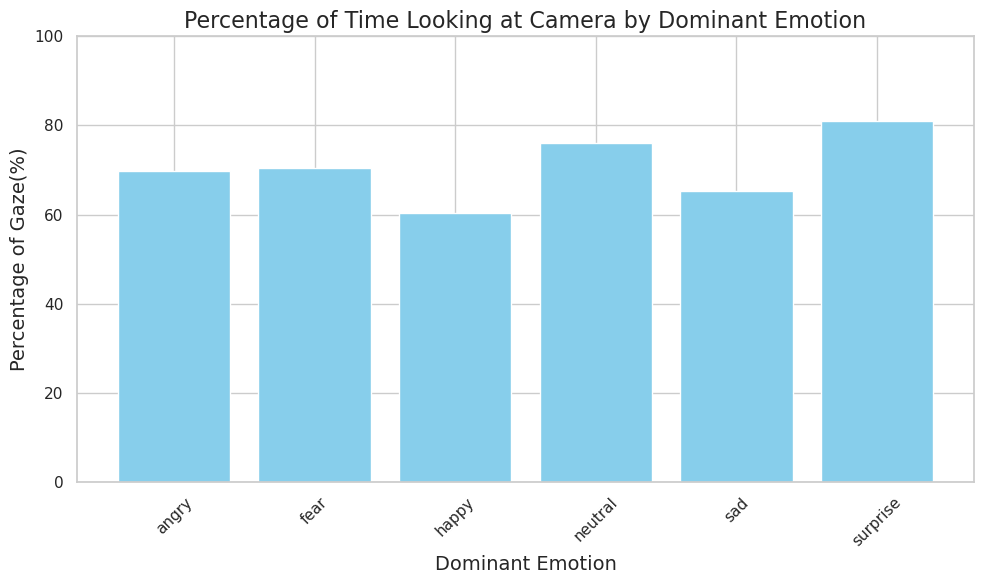

In [70]:
gaze_percentage = (
    emotion_gaze_combined.groupby('dominant_emotion')['gaze']
    .agg(lambda x: (x == 1).mean() * 100)  # Calculate percentage of gaze == 1
    .reset_index()
)

# Rename columns for clarity
gaze_percentage.columns = ['Dominant Emotion', 'Percentage of Gaze = 1']

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(gaze_percentage['Dominant Emotion'], gaze_percentage['Percentage of Gaze = 1'], color='skyblue')

# Adding titles and labels
plt.title('Percentage of Time Looking at Camera by Dominant Emotion', fontsize=16)
plt.ylabel('Percentage of Gaze(%)', fontsize=14)
plt.xlabel('Dominant Emotion', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100%

# Show the plot
plt.tight_layout()
plt.savefig('percentage_of_time_looking_at_camera_by_dominant_emotion.png', dpi=300)

plt.show()

### eye offsets vs emotions

In [ ]:
sns.boxplot(x='candidate_id', y='eye_offset', data=emotion_gaze_combined)
plt.title('Eye Offset Distribution Across Candidates')
plt.show()

### blink

### 9. Correlation Between Gaze, Blink, and Emotions:


# extract key skills and area of interest

<Figure size 1200x600 with 0 Axes>

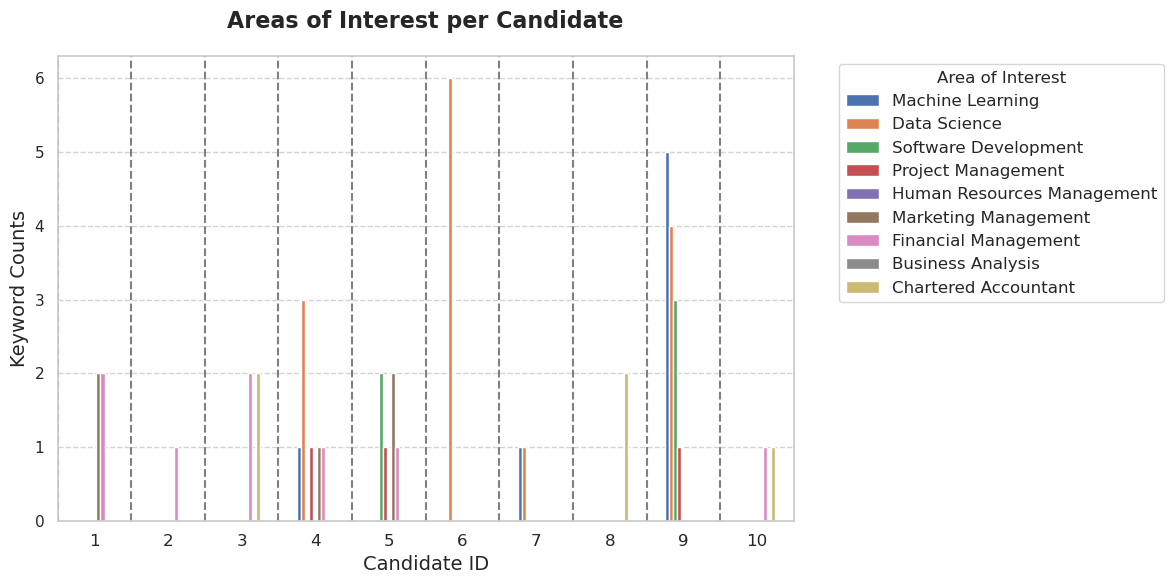

In [95]:
areas_of_interest = {
    'Machine Learning': ['machine learning', 'deep learning', 'artificial intelligence', 'neural networks', 'supervised learning', 'unsupervised learning', 'reinforcement learning', 'model training'],
    'Data Science': ['data science', 'data analysis', 'analytics', 'data mining', 'statistical analysis', 'big data', 'data visualization', 'data wrangling', 'python', 'sql', 'artificial intelligence'],
    'Software Development': ['software development', 'programming', 'coding', 'development', 'software engineering', 'web development', 'full-stack', 'front-end', 'back-end', 'agile', 'devops'],
    'Project Management': ['project management', 'agile', 'scrum', 'project', 'stakeholder management', 'risk management', 'time management', 'resource allocation', 'project planning', 'kanban'],
    'Human Resources Management': ['human resources', 'talent acquisition', 'recruitment', 'employee engagement', 'hr policies', 'performance management', 'succession planning', 'training and development', 'labor laws'],
    'Marketing Management': ['management','marketing management', 'brand management', 'digital marketing', 'advertising', 'seo', 'content marketing', 'market research', 'customer segmentation', 'campaign management', 'social media marketing'],
    'Financial Management': ['management','financial management', 'corporate finance', 'financial planning','accounting', 'budgeting', 'forecasting', 'investment management', 'cost accounting', 'risk management', 'financial analysis', 'investment'],
    'Business Analysis': ['business analysis', 'requirements gathering', 'stakeholder engagement', 'business process modeling', 'swot analysis', 'business intelligence', 'data-driven decisions'],
    'Chartered Accountant': ['chartered accountant', 'cfa' ,'accounting', 'financial auditing', 'taxation', 'financial reporting', 'gst', 'indirect tax', 'direct tax', 'accounting standards', 'balance sheet', 'income statement', 'cash flow statement', 'financial statements']

}

# Initialize a list to store area of interest counts
aois_data = []

# Loop through each candidate's transcript
for index, row in transcripts.iterrows():
    candidate_id = row['candidate_id']
    transcript = row['transcript_text']
    
    # Initialize a dictionary to hold counts for each area of interest
    counts = {area: 0 for area in areas_of_interest.keys()}
    
    # Count keywords for each area of interest
    for area, keywords in areas_of_interest.items():
        for keyword in keywords:
            counts[area] += transcript.lower().count(keyword)
    
    # Add candidate_id to counts and append to the data list
    counts['candidate_id'] = candidate_id
    aois_data.append(counts)

# Create a DataFrame from the collected data
aois_df = pd.DataFrame(aois_data)

# Set candidate_id as index for easier visualization
aois_df.set_index('candidate_id', inplace=True)

# Plotting the areas of interest for each candidate
plt.figure(figsize=(12, 6))
ax = aois_df.plot(kind='bar', stacked=False, figsize=(12, 6), grid=False)

# Customize the plot
plt.title('Areas of Interest per Candidate', fontsize=16, weight='bold', pad=20)
plt.ylabel('Keyword Counts', fontsize=14)
plt.xlabel('Candidate ID', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Area of Interest', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Get candidate boundaries and draw darker vertical lines
boundaries = range(len(aois_df))
for boundary in boundaries:
    ax.axvline(x=boundary - 0.5, color='gray', linestyle='--', lw=1.5)

# Add a vertical grid only for major candidate boundaries
plt.grid(True, axis='y', linestyle='--', color='lightgray')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('area_of_interest_per_candidate_with_boundaries.png', dpi=300)
plt.show()

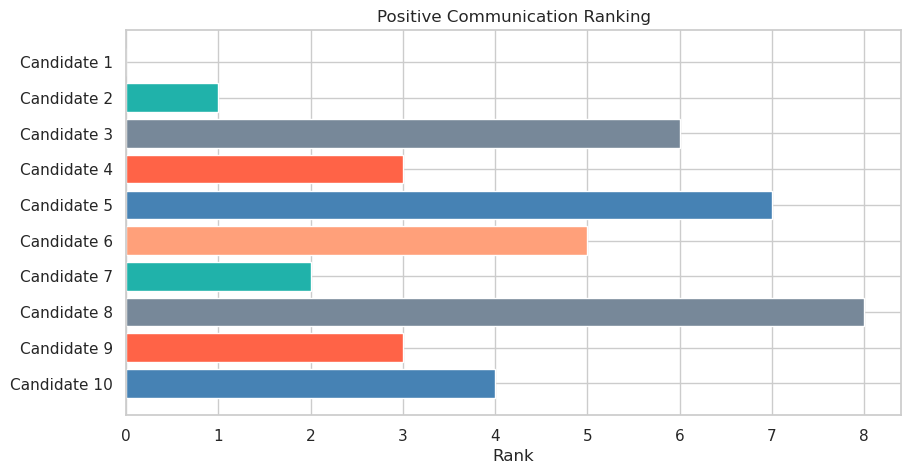

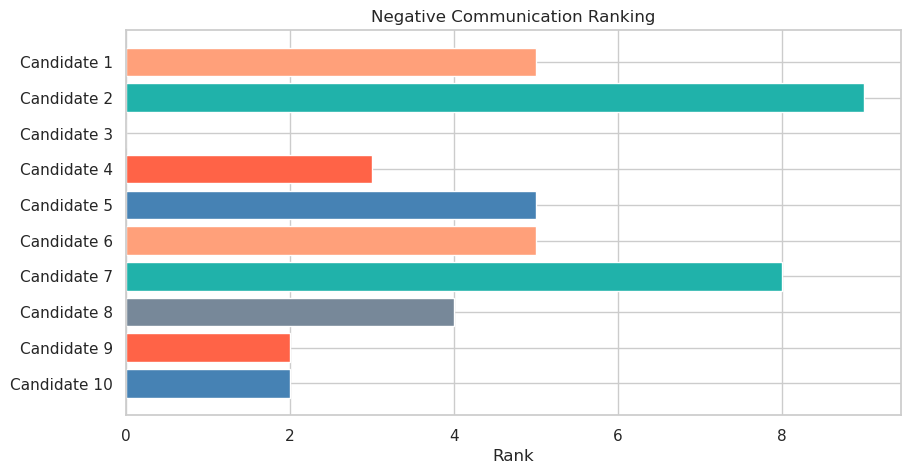

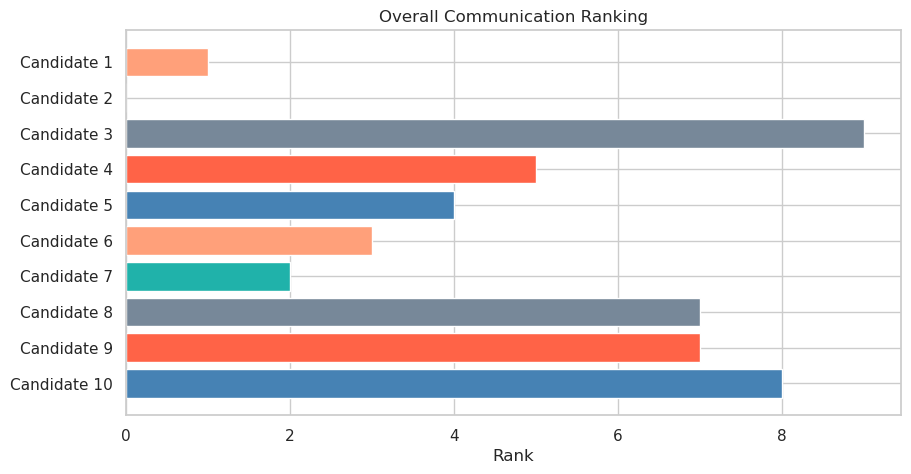

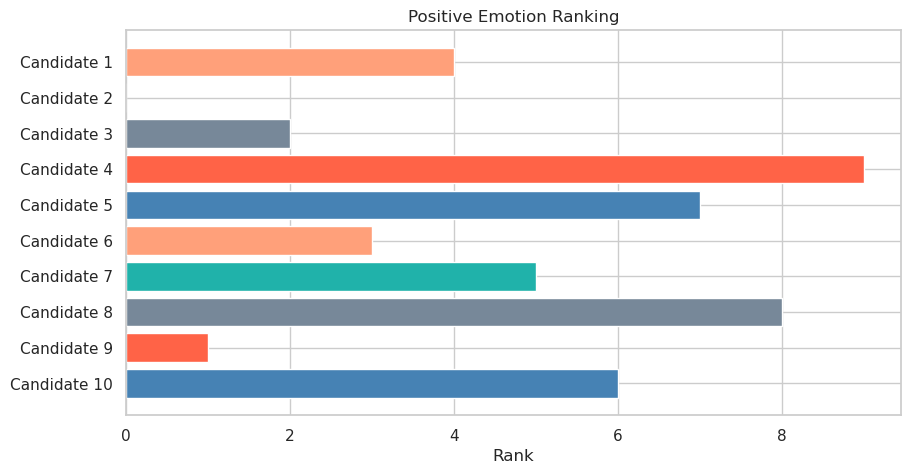

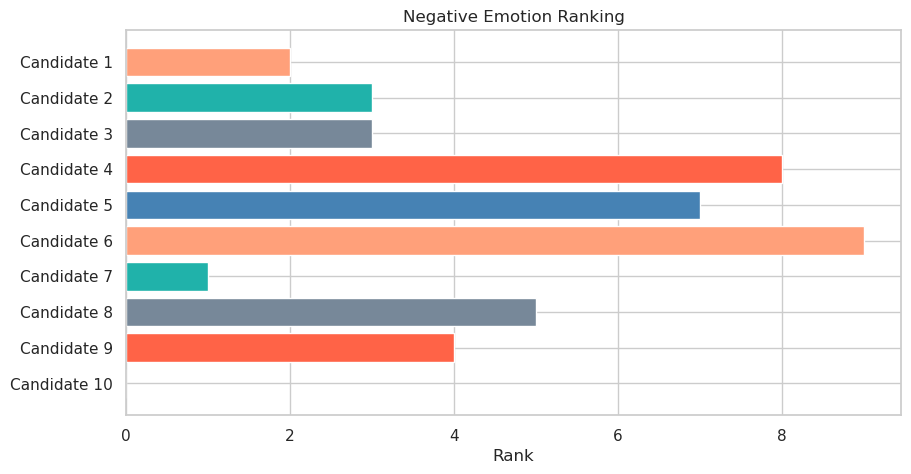

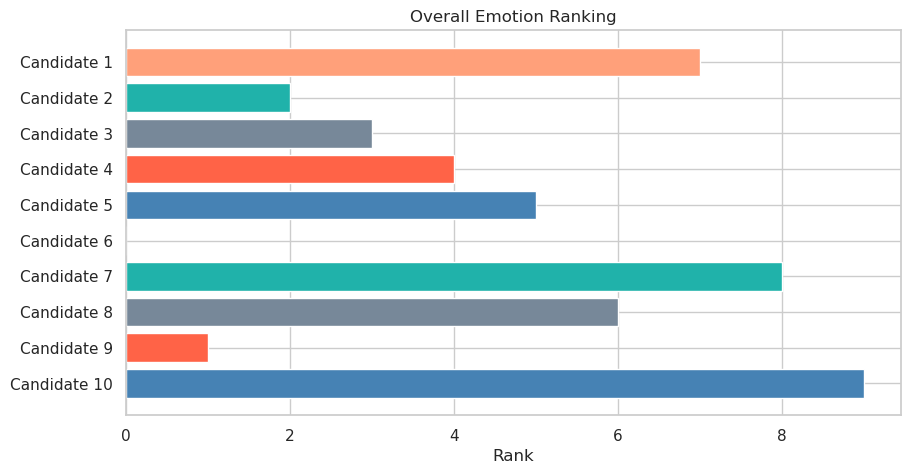

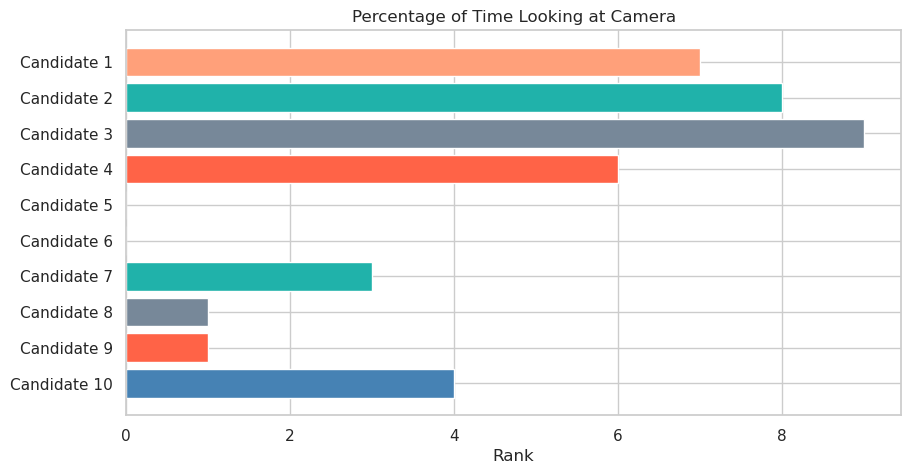

In [98]:
candidates = ['Candidate 1', 'Candidate 2', 'Candidate 3', 'Candidate 4', 'Candidate 5', 
              'Candidate 6', 'Candidate 7', 'Candidate 8', 'Candidate 9', 'Candidate 10', 
              'Candidate 16']

# Rank Data (smaller number means better rank)
positive_comm = [0, 1, 6, 3, 7, 5, 2, 8, 3, 4]  # For 16th use same as candidate 2
negative_comm = [5, 9, 0, 3, 5, 5, 8, 4, 2, 2]
overall_comm = [1, 0, 9, 5, 4, 3, 2, 7, 7, 8]

positive_emotion = [4, 0, 2, 9, 7, 3, 5, 8, 1, 6]
negative_emotion = [2, 3, 3, 8, 7, 9, 1, 5, 4, 0]
overall_emotion = [7, 2, 3, 4, 5, 0, 8, 6, 1, 9]

camera_time = [7, 8, 9, 6, 0, 0, 3, 1, 1, 4]

# Define a function for plotting bar charts
def plot_ranking(scores, title, colors):
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(candidates[:-1]))  # Exclude Candidate 16 from list for now
    ax.barh(y_pos, scores, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(candidates[:-1])
    ax.invert_yaxis()  # Highest rank at the top
    ax.set_xlabel('Rank')
    ax.set_title(title)
    plt.show()

# Define color scheme
color_scheme = ['#FFA07A', '#20B2AA', '#778899', '#FF6347', '#4682B4']

# Plot all categories
plot_ranking(positive_comm, 'Positive Communication Ranking', color_scheme)
plot_ranking(negative_comm, 'Negative Communication Ranking', color_scheme)
plot_ranking(overall_comm, 'Overall Communication Ranking', color_scheme)

plot_ranking(positive_emotion, 'Positive Emotion Ranking', color_scheme)
plot_ranking(negative_emotion, 'Negative Emotion Ranking', color_scheme)
plot_ranking(overall_emotion, 'Overall Emotion Ranking', color_scheme)

plot_ranking(camera_time, 'Percentage of Time Looking at Camera', color_scheme)